# Compare swr detection with mua detection

The idea is that units should increase their firing during HPC ripples. Being so, ripples without increased unit firing might be false positives. 

In [ ]:
import glob
import pandas as pd
import os
import pickle 
import numpy as np
import math 
from matplotlib import pyplot as plt

import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
import itertools
from ripple_detection.core import get_multiunit_population_firing_rate

from scipy import stats
from ripple_detection.core import gaussian_smooth, get_envelope

## Import mua data

In [2]:
df_mua = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\multiunit_data\post_processed\mua_df.csv')
df_mua

,Unnamed: 0,start_time,end_time,peak_time,ripple_duration,session,ep_type,group
0,0,64.0895,64.3285,64.2555,0.239,LEM3116_S20180715121821,track,control
1,1,69.6875,69.8525,69.7725,0.165,LEM3116_S20180715121821,track,control
2,2,75.6615,75.7805,75.7065,0.119,LEM3116_S20180715121821,track,control
3,3,76.6735,76.8635,76.7755,0.190,LEM3116_S20180715121821,track,control
4,4,82.6235,82.7045,82.6595,0.081,LEM3116_S20180715121821,track,control
...,...,...,...,...,...,...,...,...
52908,52908,1474.8415,1475.0365,1474.9495,0.195,RH16_S20161207130000,track,pae
52909,52909,1517.8405,1517.9865,1517.9345,0.146,RH16_S20161207130000,track,pae
52910,52910,1517.9935,1518.2105,1518.1185,0.217,RH16_S20161207130000,track,pae
52911,52911,1532.9235,1532.9785,1532.9515,0.055,RH16_S20161207130000,track,pae


## load raw swr

In [3]:
save_path = "F:/Projects/PAE_PlaceCell/analysis/swr_data/"
sessions = glob.glob(save_path + '*.pkl')
ripple_map = []
filtered_map = []
phase_map = []
amp_map = []

freq_map = []

df_swr=pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        ripple_times = pickle.load(f)
        ripple_maps = pickle.load(f)
    ripple_map.append(ripple_maps["ripple_map"])
    filtered_map.append(ripple_maps['filtered_map'])
    phase_map.append(ripple_maps['phase_map'])
    amp_map.append(ripple_maps['amp_map'])
    freq_map.append(ripple_maps['freq_map'])

    # add data frame of ripple features and add session id
    base = os.path.basename(session)
    ripple_times['session'] = os.path.splitext(base)[0]
    df_swr = df_swr.append(ripple_times,ignore_index=True)

ripple_map = np.vstack(ripple_map)     
filtered_map = np.vstack(filtered_map)     
phase_map = np.vstack(phase_map)     
amp_map = np.vstack(amp_map)     
freq_map = np.vstack(freq_map) 

# make maps dict 
ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}
df_swr

,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,session
0,43.1928,43.5208,0.3280,0.996477,43.4600,6,27.128862,161.202208,LEM3116_S20180715121821
1,45.0672,45.2528,0.1856,0.992112,45.1936,6,8.591904,134.656664,LEM3116_S20180715121821
2,45.3272,46.3672,1.0400,0.995808,45.5496,7,8.217257,133.494733,LEM3116_S20180715121821
3,46.4232,46.7064,0.2832,0.989954,46.6000,3,7.793470,179.299053,LEM3116_S20180715121821
4,46.7288,46.9312,0.2024,0.996390,46.7976,3,9.532922,251.885405,LEM3116_S20180715121821
...,...,...,...,...,...,...,...,...,...
93313,1217.7592,1217.9560,0.1968,0.151498,1217.8024,4,7.624294,104.172444,RH16_S20161207130000
93314,1261.5736,1261.6376,0.0640,0.110154,1261.6072,4,4.028226,77.108185,RH16_S20161207130000
93315,1284.0200,1284.2024,0.1824,0.191058,1284.1200,6,46.104708,48.395690,RH16_S20161207130000
93316,1297.3584,1297.4888,0.1304,0.110988,1297.4184,3,41.691450,154.769416,RH16_S20161207130000


### do some slight processing to remove some obvious false positives

Below, I keep ripple that do not show major clipping, are less than 1 second, and have a frequency above 50 hz

In [4]:
def clipped(x, axis=1):
    x_diff = np.diff(x,axis=1)
    return np.sum(x_diff==0,axis=1) / x_diff.shape[1]
    
def clip_filter(ripple_times,ripple_maps,clip_thres=0.05):
    
    ripple_times['clipped'] = clipped(ripple_maps['ripple_map'])
    idx = ripple_times.clipped < clip_thres
    
    for key in ripple_maps.keys():
        ripple_maps[key] = ripple_maps[key][idx]
        
    ripple_times = ripple_times[idx]
    
    return ripple_times,ripple_maps

df_swr,ripple_maps = clip_filter(df_swr,ripple_maps)

# remove less than a second from swr
idx = df_swr.ripple_duration < 1
for key in ripple_maps.keys():
        ripple_maps[key] = ripple_maps[key][idx]
df_swr = df_swr[idx]


# remove less than a second from mua
df_mua = df_mua[df_mua.ripple_duration < 1]


# remove frequency below 50hz
idx = df_swr.peak_freq > 50
for key in ripple_maps.keys():
        ripple_maps[key] = ripple_maps[key][idx]
df_swr = df_swr[idx]

display(df_swr)
display(df_mua)

,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,session,clipped
0,43.1928,43.5208,0.3280,0.996477,43.4600,6,27.128862,161.202208,LEM3116_S20180715121821,0.006667
1,45.0672,45.2528,0.1856,0.992112,45.1936,6,8.591904,134.656664,LEM3116_S20180715121821,0.000000
3,46.4232,46.7064,0.2832,0.989954,46.6000,3,7.793470,179.299053,LEM3116_S20180715121821,0.000000
4,46.7288,46.9312,0.2024,0.996390,46.7976,3,9.532922,251.885405,LEM3116_S20180715121821,0.006667
5,53.1464,53.8504,0.7040,0.997383,53.2944,4,54.575386,142.929008,LEM3116_S20180715121821,0.000000
...,...,...,...,...,...,...,...,...,...,...
93311,1189.0424,1189.2416,0.1992,0.142649,1189.1168,2,3.138093,181.669837,RH16_S20161207130000,0.013333
93312,1206.8240,1206.9872,0.1632,0.148389,1206.9280,2,4.969388,185.006176,RH16_S20161207130000,0.000000
93313,1217.7592,1217.9560,0.1968,0.151498,1217.8024,4,7.624294,104.172444,RH16_S20161207130000,0.006667
93314,1261.5736,1261.6376,0.0640,0.110154,1261.6072,4,4.028226,77.108185,RH16_S20161207130000,0.026667


,Unnamed: 0,start_time,end_time,peak_time,ripple_duration,session,ep_type,group
0,0,64.0895,64.3285,64.2555,0.239,LEM3116_S20180715121821,track,control
1,1,69.6875,69.8525,69.7725,0.165,LEM3116_S20180715121821,track,control
2,2,75.6615,75.7805,75.7065,0.119,LEM3116_S20180715121821,track,control
3,3,76.6735,76.8635,76.7755,0.190,LEM3116_S20180715121821,track,control
4,4,82.6235,82.7045,82.6595,0.081,LEM3116_S20180715121821,track,control
...,...,...,...,...,...,...,...,...
52908,52908,1474.8415,1475.0365,1474.9495,0.195,RH16_S20161207130000,track,pae
52909,52909,1517.8405,1517.9865,1517.9345,0.146,RH16_S20161207130000,track,pae
52910,52910,1517.9935,1518.2105,1518.1185,0.217,RH16_S20161207130000,track,pae
52911,52911,1532.9235,1532.9785,1532.9515,0.055,RH16_S20161207130000,track,pae


In [5]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def get_lfp(df,i):
    data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'

    # get data session path from mat file
    path = get_session_path(data_path+df.session.iloc[i]+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def get_spikes(filename):
    data = hdf5storage.loadmat(filename,variable_names=['Spikes'])
    spike_times=data['Spikes']
    spike_times=np.squeeze(spike_times)
    for i in range(spike_times.shape[0]):
        spike_times[i]=np.squeeze(spike_times[i])
    return spike_times

def makegausslpfir(Fc=100, Fs=1250, s=4):
    # % makegausslpfir        Gaussian LP filter
    # %
    # % win = makegausslpfir( Fc, Fs, s )
    # %
    # % Fc    corner frequency [Hz]
    # % Fs    sampling frequency [Hz]
    # % s     support [SD], minimum 3, default 4
    # %
    # % win   fir
    # %
    # % see also  firfilter

    # % 02-oct-13 ES
    # 20-dec-20 RH to python
    
    s = max( s, 3 )

    sd = Fs / ( 2 * np.pi * Fc )
    x = np.arange(-math.ceil( s * sd ), math.ceil( s * sd ))
    gwin = 1/( 2 * np.pi * sd ) * np.exp( -( x**2/2/sd**2 ) )
    gwin = gwin / sum( gwin )

    return gwin

def firfilt(x,W):
    from scipy import signal

    # % FIRFILT       FIR filtering with zero phase distortion.
    # %
    # %               matrix columns are filtered;
    # %               output is a column vector / matrix.

    # % 19-Jul-02 ES
    # % 27-jan-03 zero phase lag
    # 20-dec-20 RH to python
    
    C = len(W)
    D = math.ceil(C/2) - 1

    x = np.concatenate((np.flipud(x[0:C]),x,np.flipud(x[len(x)-C-1:-1])))
    Y = signal.lfilter(W,1,x)
    Y = Y[C+D:len(Y)-C+D]

    return Y

def bandpass_filter(signal,rip_bp=[80,250],fs=1250):
    # filter and process ripples, using Eran's defaults (diff of Gaussians)
    hRip1 = makegausslpfir(rip_bp[0], fs, 6 )
    hRip2 = makegausslpfir(rip_bp[1], fs, 6 )
    high = firfilt( signal, hRip2 )   # highpass filter
    lo = firfilt( high, hRip1 )   # lowpass filter         
    return high - lo # difference of Gaussians

#### Pull in lfp and mua to plot example

In [6]:
def plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,session,lims=20,rip_n=0):
    # look at current session only
    df = df[(df.session == session)]
    
    # find time window around ripple
    lower_lim = df.peak_time.iloc[rip_n] - lims
    upper_lim = df.peak_time.iloc[rip_n] + lims
    
    # locate channel that maximized ripple power
    peak_ch = df.peak_channel.iloc[rip_n]
    
    # restrict to just that time window
    temp_df = df[(df.start_time >= lower_lim) & (df.end_time <= upper_lim)]
    
    # find index for time window for lfp
    lfp_idx = (ts_lfp >= lower_lim) & (ts_lfp <= upper_lim)
    
    # zscore lfp for plotting
    zscore_lfp = stats.zscore(lfp[lfp_idx,peak_ch],axis=0)
    
    # plot lfp trace
    ax.plot(ts_lfp[lfp_idx],zscore_lfp + 5,color='#0b032a',label='raw lfp')  
    
    # bandpass filter lfp trace to ripple range and zscore for plotting
    signal = stats.zscore(bandpass_filter(lfp[lfp_idx,peak_ch]),axis=0)
    
    # plot filtered signal
    ax.plot(ts_lfp[lfp_idx],signal,color='#621940',alpha=.5,label='filtered lfp') 
    
    # get envelope
    smooth_envelope = gaussian_smooth(get_envelope(signal),0.004,1250)
    ax.plot(ts_lfp[lfp_idx],smooth_envelope,color='#843b62',label='envelope') 
    
    # find index for time window for mua
    mua_idx = (ts_mua >= lower_lim) & (ts_mua <= upper_lim)
    
    # plot zscored mua
    ax.plot(ts_mua[mua_idx],stats.zscore(firing_rate[mua_idx],axis=0)-10,color='#ED553B',label='mua')

    # plot spike raster within window
    for i,s in enumerate(spike_times):
        s = s[(s >= lower_lim) & (s <= upper_lim)]
        ax.plot(s,np.zeros(len(s))-15-i,'|',color='#0b032a')

    # plot swr times within window
    for ripple in temp_df.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#843b62', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#843b62', zorder=1000)

    # plot mua times within window
    temp_df_mua = df_mua[(df_mua.session == session) & (df_mua.start_time >= lower_lim) & (df_mua.end_time <= upper_lim)]
    for ripple in temp_df_mua.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#ED553B', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#ED553B', zorder=1000)
        
    ax.legend(loc='upper right')
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('time (sec)')
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    left_side = ax.spines["left"]
    left_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

### load data to plot example

In [7]:
session = np.where(df_swr.session=='LEM3216_S20190805141510')[0][0]
# session = np.where(df_swr.session=='LS19_S20170622141707')[0][0]

lfp,ts_lfp = get_lfp(df_swr,session)

# load spikes
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
spike_times = get_spikes(data_path+df_swr.session.iloc[session]+'.mat')

# bin spikes into single vector
st = list(itertools.chain.from_iterable(spike_times))
dt = 0.001
multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
# timestamps for binned spikes
ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
firing_rate = get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

### plot example

* Shaded purple are detected ripple events

* Shaded orange are detected mua events

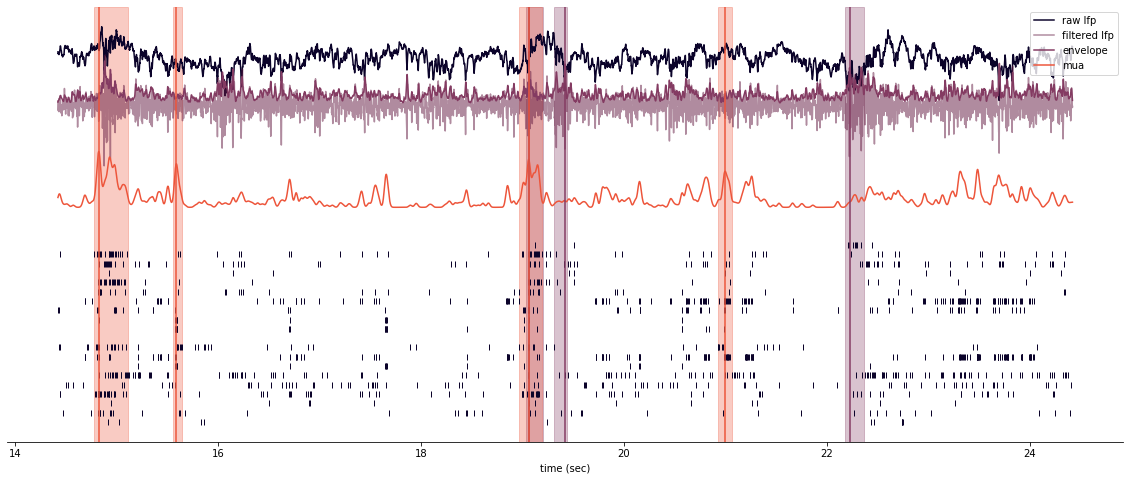

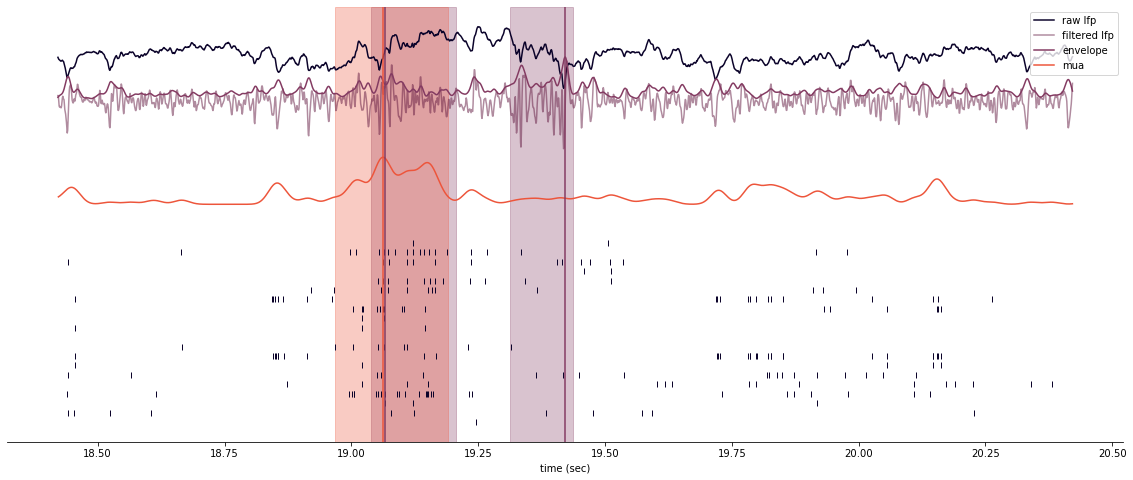

In [8]:
rip_n = 10
fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=1,rip_n=rip_n)

### check to find detected ripples overlap with of mua events

In [9]:
ripple_map_temp = []
filtered_map_temp = []
phase_map_temp = []
amp_map_temp = []
freq_map_temp = []

df=pd.DataFrame()

from IPython.display import clear_output
i=1

condition = []
for event in df_mua.itertuples():
    clear_output(wait=True)
    
    condition.append((df_swr.session == event.session) & (df_swr.peak_time >= event.start_time) & (df_swr.end_time <= event.end_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.start_time) & (df_swr.end_time >= event.start_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.end_time) & (df_swr.end_time >= event.end_time))
    idx = condition[0] | condition[1] | condition[2]
    condition = [] 
        
    ripple_map_temp.append(ripple_maps["ripple_map"][idx])
    filtered_map_temp.append(ripple_maps["filtered_map"][idx])
    phase_map_temp.append(ripple_maps["phase_map"][idx])
    amp_map_temp.append(ripple_maps["amp_map"][idx])
    freq_map_temp.append(ripple_maps["freq_map"][idx])
    
    event_times = df_swr[idx]
    df = df.append(event_times,ignore_index=True)
    
    i+=1
    print("Current progress:",np.round(i/len(df_mua)*100,2),"%")
    
ripple_map = np.vstack(ripple_map_temp)     
filtered_map = np.vstack(filtered_map_temp)     
phase_map = np.vstack(phase_map_temp)     
amp_map = np.vstack(amp_map_temp)     
freq_map = np.vstack(freq_map_temp)  

ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}

df 

Current progress: 100.0 %


,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,session,clipped
0,211.2496,211.3280,0.0784,0.990871,211.2976,3,4.908209,215.098450,LEM3116_S20180715121821,0.000000
1,517.9208,518.3120,0.3912,0.995188,518.0888,7,27.180700,213.760783,LEM3116_S20180715121821,0.000000
2,607.9360,608.3280,0.3920,0.990928,607.9664,3,8.437211,95.847679,LEM3116_S20180715121821,0.000000
3,675.9872,676.1400,0.1528,0.994272,676.0512,6,5.047723,238.978736,LEM3116_S20180715121821,0.000000
4,933.2272,933.3896,0.1624,0.992893,933.2808,7,25.302185,108.979916,LEM3116_S20180715121821,0.000000
...,...,...,...,...,...,...,...,...,...,...
15501,420.6976,420.8128,0.1152,0.235421,420.7560,5,6.232112,192.427096,RH16_S20161030145324,0.000000
15502,255.4520,255.5992,0.1472,0.314032,255.5336,7,6.348210,93.474621,RH16_S20161126145021,0.000000
15503,233.4200,233.5776,0.1576,0.260312,233.4976,7,5.317187,110.776625,RH16_S20161126150318,0.000000
15504,270.2888,270.4112,0.1224,0.065024,270.3296,0,2.797337,181.321353,RH16_S20161126150318,0.000000


### remove duplicates

In [10]:
idx = (~df.start_time.duplicated(keep='first')) & (~df.peak_freq.duplicated(keep='first'))

df = df[idx]
for key in ripple_maps.keys():
    ripple_maps[key] = ripple_maps[key][idx]
df

,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,session,clipped
0,211.2496,211.3280,0.0784,0.990871,211.2976,3,4.908209,215.098450,LEM3116_S20180715121821,0.000000
1,517.9208,518.3120,0.3912,0.995188,518.0888,7,27.180700,213.760783,LEM3116_S20180715121821,0.000000
2,607.9360,608.3280,0.3920,0.990928,607.9664,3,8.437211,95.847679,LEM3116_S20180715121821,0.000000
3,675.9872,676.1400,0.1528,0.994272,676.0512,6,5.047723,238.978736,LEM3116_S20180715121821,0.000000
4,933.2272,933.3896,0.1624,0.992893,933.2808,7,25.302185,108.979916,LEM3116_S20180715121821,0.000000
...,...,...,...,...,...,...,...,...,...,...
15500,202.2248,202.2736,0.0488,0.171878,202.2496,1,11.372665,51.914166,RH16_S20161030145324,0.000000
15502,255.4520,255.5992,0.1472,0.314032,255.5336,7,6.348210,93.474621,RH16_S20161126145021,0.000000
15503,233.4200,233.5776,0.1576,0.260312,233.4976,7,5.317187,110.776625,RH16_S20161126150318,0.000000
15504,270.2888,270.4112,0.1224,0.065024,270.3296,0,2.797337,181.321353,RH16_S20161126150318,0.000000


### save new df and maps

In [ ]:
os.mkdir(save_path+'post_processed')

df.to_csv(save_path+'post_processed/swr_df.csv')

# save file
with open(save_path+'post_processed/swr_df_maps', 'wb') as f:
    pickle.dump(ripple_times, f)
    pickle.dump(ripple_maps, f)

### plot example with new df where ripples must overlap mua

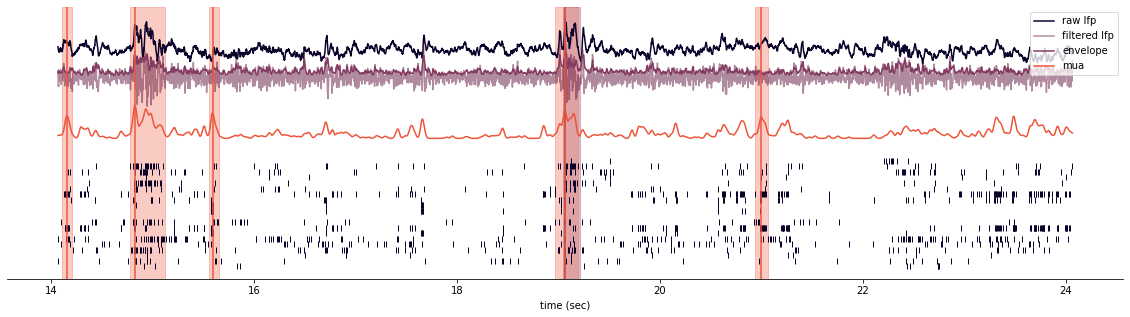

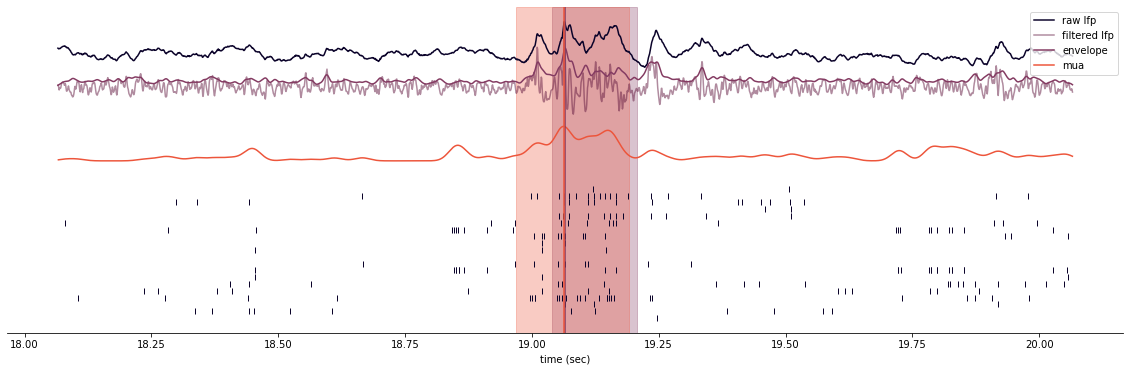

In [14]:
rip_n = 2
fig, ax = plt.subplots(1,1,figsize=(20, 5))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=1,rip_n=rip_n)

### make sure the overlap between ripple and mua is substantial

In [ ]:
# def get_mua_fr(session,dt = 0.001):
#     # load spikes
#     data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
#     spike_times = get_spikes(data_path+session+'.mat')
#     # bin spikes into single vector
#     st = list(itertools.chain.from_iterable(spike_times))
#     multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
#     # timestamps for binned spikes
#     ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
#     return ts_mua,get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

# def get_percent_overlap(df):
#     above_mean = []
#     # loop through each session
#     for session in pd.unique(df.session):
#         # pull out individual session
#         temp_df = df[df.session == session]
#         # get z scored mua firing rate
#         ts_mua, fr = get_mua_fr(session)
#         zscored_fr = stats.zscore(fr,axis=0)
#         # loop through each ripple event
#         for event in temp_df.itertuples():
#             # pull out mua firing rate during ripple
#             mua_values = zscored_fr[(ts_mua >= event.start_time) & (ts_mua <= event.end_time)]
#             # calculate the proportion where mua values are above the mean and save
#             above_mean.append(sum(mua_values > 0) / len(mua_values))
#     return above_mean

# above_mean = get_percent_overlap(df)
# df['ripple_mua_overlap'] = above_mean

# plt.figure(figsize=(20,4))
# plt.plot(above_mean)

# plt.figure(figsize=(4,4))
# plt.hist(above_mean,100)
# plt.show()


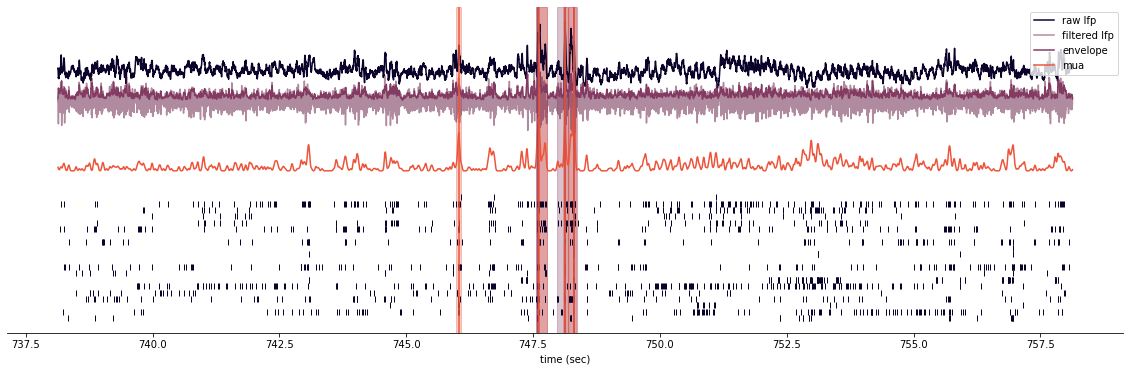

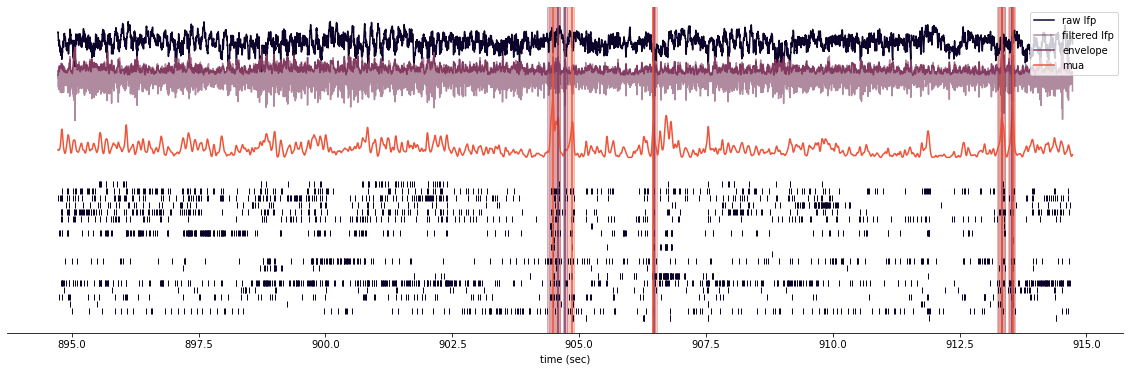

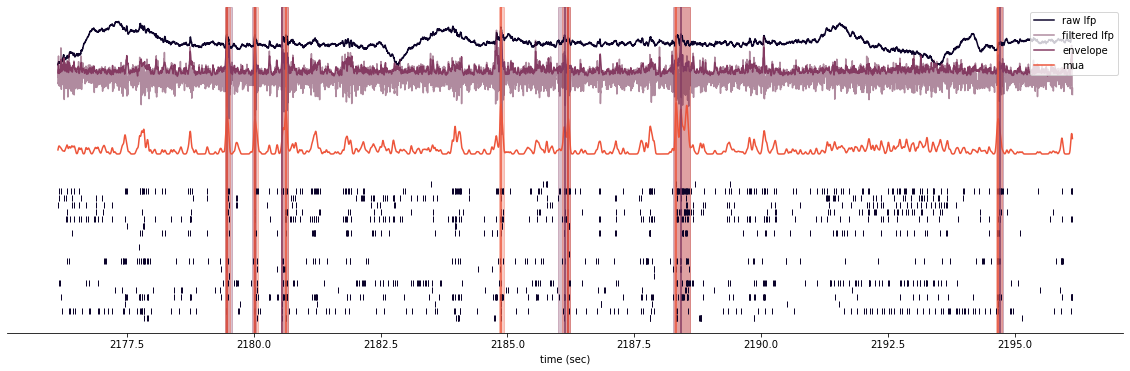

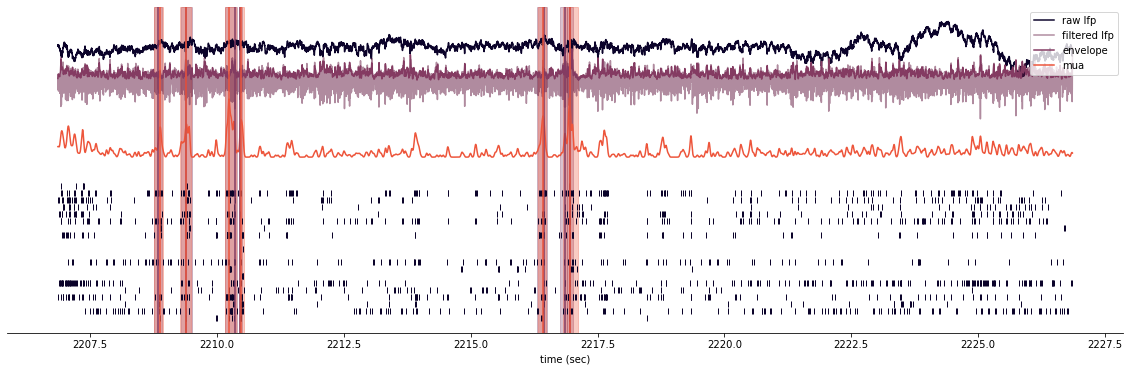

In [134]:
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=92)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=107)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=294)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=307)

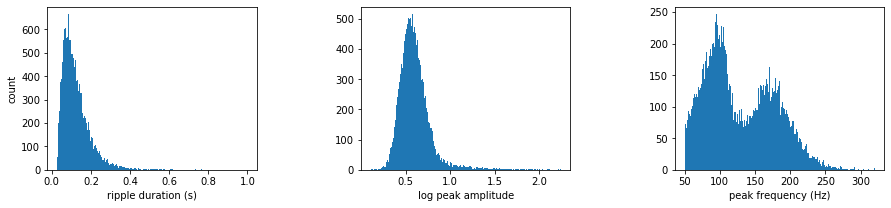

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15, 3), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

axs[0].hist(df.ripple_duration,200)
axs[0].set_ylabel('count')
axs[0].set_xlabel('ripple duration (s)')

axs[1].hist(np.log10(df.peak_amplitude),200)
axs[1].set_xlabel('log peak amplitude')

axs[2].hist(df.peak_freq,200)
axs[2].set_xlabel('peak frequency (Hz)')

plt.show()

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['ripple_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['freq_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['filtered_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['amp_map'][idx].T)
    axs[i].set_title(s)